In [3]:
dependencies = [
    "fastai",
    "timm"
]

!pip install -U {" ".join(dependencies)}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 0.9.16
    Uninstalling timm-0.9.16:
      Successfully uninstalled timm-0.9.16


In [4]:
import gc

from fastai.imports import *
from fastai.vision.all import *

import matplotlib.pyplot as plt

In [5]:
import torch
import gc

def report_gpu():
    print(torch.cuda.list_gpu_processes())
    gc.collect()
    torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
def get_dls(path, presize, resize, bs):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, 
        item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=bs, device=device)

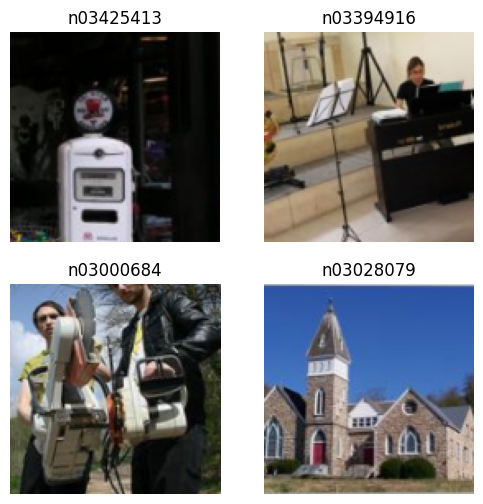

In [5]:
path = untar_data(URLs.IMAGENETTE_160)

dls = get_dls(path, 160, 128, 64)
dls.show_batch(max_n=4)

# Can Very Deep Models Do As Good As Shallow Ones

### First Let's Get A Baseline Accuracy With A Simple FCN Model

In [6]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)

def get_learner(m, bs):
    return Learner(get_dls(path, 160, 128, bs=bs),
                   m,
                   loss_func=nn.CrossEntropyLoss(),
                   metrics=accuracy,
                   cbs=ActivationStats(with_hist=True)).to_fp16()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


SuggestedLRs(slide=0.0831763744354248, valley=0.0012022644514217973)

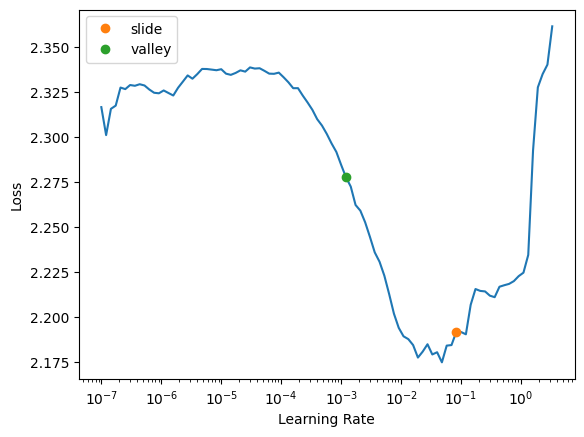

In [7]:
# we take the same 5 conv layers from the fcn_model and added 20 more layers that do nothing
def fcn_model(useless_layers=0):
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))


learn = get_learner(fcn_model(useless_layers=0), bs=64)
learn.lr_find(suggest_funcs=(slide, valley))

In [8]:
abs((0.2089296132326126 - 0.04786301031708717)) / 2

0.08053330145776272

In [9]:
learn.fit_one_cycle(3, 0.0805333, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.936291,4.863692,0.207389,00:36
1,1.653640,1.669606,0.471338,00:39
2,1.324496,1.272980,0.599745,00:38


### Then Let's Try Adding One Layer To the FCN Model

SuggestedLRs(slide=0.03981071710586548, valley=0.0014454397605732083)

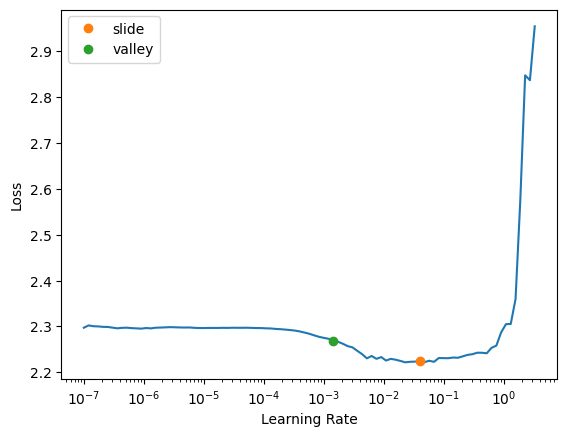

In [12]:
# we take the same 5 conv layers from the fcn_model and added 20 more layers that do nothing
def deep_fcn_model(more_layers):
    layers = [
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
    ]

    for _ in range(more_layers):
        layers.append(nn.Linear(256, 256))
        layers.append(nn.ReLU(inplace=True))

    # Final output layer
    layers.append(nn.Linear(256, 10))
    return nn.Sequential(*layers)


learn = get_learner(deep_fcn_model(more_layers=1), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

In [13]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(3, best_lr, wd=0.1)

0.019182638672646135


epoch,train_loss,valid_loss,accuracy,time
0,1.890995,1.920357,0.318726,00:46
1,1.556566,1.378529,0.547006,00:43
2,1.251789,1.197629,0.614268,00:41


### Same Thing But This Time We Make The Model Much Deeper

SuggestedLRs(slide=0.005248074419796467, valley=0.0003311311302240938)

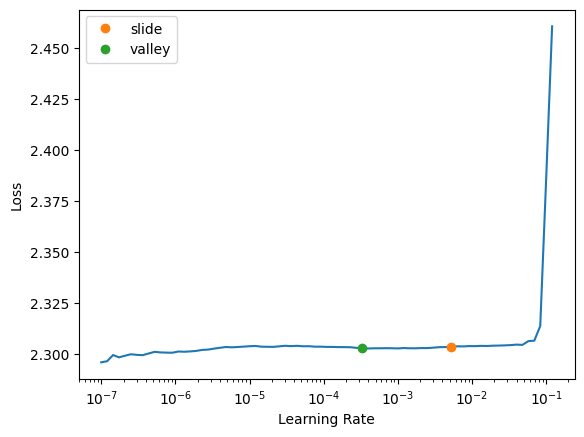

In [14]:
learn = get_learner(deep_fcn_model(more_layers=10), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

In [15]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(3, best_lr, wd=0.1)

0.0024584716447861865


epoch,train_loss,valid_loss,accuracy,time
0,2.226762,2.191856,0.169427,00:45
1,2.140324,2.123062,0.183694,00:42
2,2.101074,2.112362,0.196688,00:41


### Doesn't Train, Ok Let's Try Regularization

In [16]:
# Define a sequential block for Linear -> BatchNorm -> ReLU
def linear_block(ni, nf):
    return nn.Sequential(
        nn.Linear(ni, nf),
        nn.BatchNorm1d(nf),
        nn.ReLU()
    )

# Define the FCN model with optional additional layers
def deep_fcn_model(more_layers=0):
    layers = [
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten()
    ]
    
    # Add the optional additional layers using linear_block
    for _ in range(more_layers):
        layers.append(linear_block(256, 256))
    
    # Final output layer
    layers.append(nn.Linear(256, 10))  # Assume dls.c = 10 for simplicity
    
    return nn.Sequential(*layers)

SuggestedLRs(slide=0.14454397559165955, valley=0.0005754399462603033)

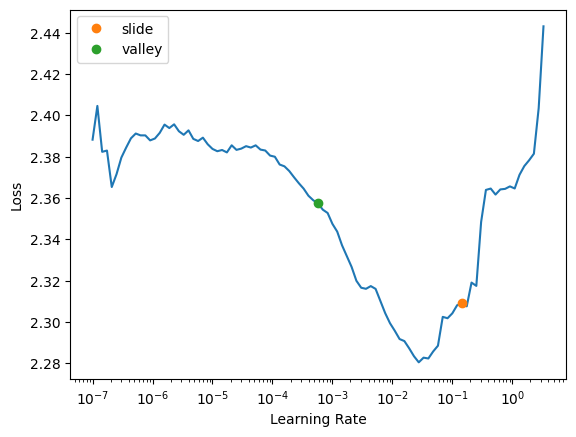

In [17]:
learn = get_learner(deep_fcn_model(more_layers=10), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

Ok regularization fixed the loss landscape and removed all those traps

In [18]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(3, best_lr, wd=0.1)

0.07198426782269962


epoch,train_loss,valid_loss,accuracy,time
0,2.215544,2.370741,0.101911,00:43
1,2.181351,2.142532,0.180892,00:43
2,2.115438,2.125121,0.198471,00:44


### Will We Be Able To Go Very Deep With The Help Of Regularization?

SuggestedLRs(slide=0.10000000149011612, valley=0.0008317637839354575)

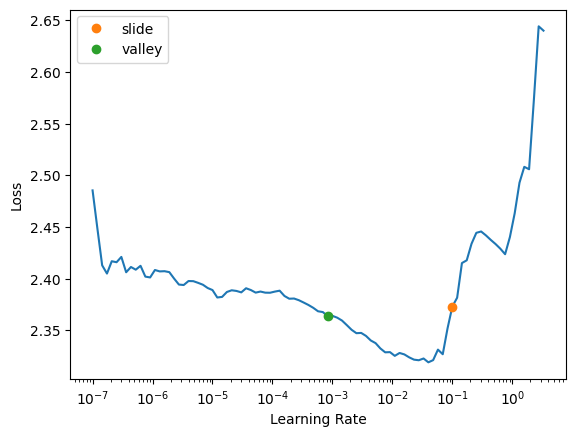

In [19]:
learn = get_learner(deep_fcn_model(more_layers=20), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

We are still using regularization and it seems there are many traps these time

In [20]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(3, best_lr, wd=0.1)

0.04958411885309033


epoch,train_loss,valid_loss,accuracy,time
0,2.330135,2.306324,0.102420,00:48
1,2.306191,2.302698,0.099108,00:48
2,2.293462,2.294625,0.120255,00:47


It trains but seems like it's getting harder because of these traps?

But the problem becomes more apparent with more layers

SuggestedLRs(slide=0.0691830962896347, valley=0.0020892962347716093)

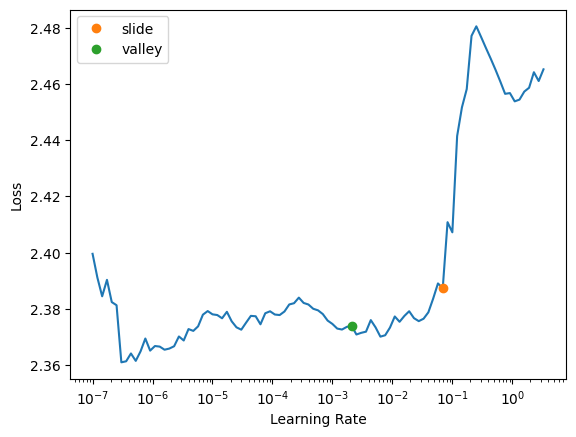

In [21]:
learn = get_learner(deep_fcn_model(more_layers=40), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

In [22]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(3, best_lr, wd=0.1)

0.03354690002743155


epoch,train_loss,valid_loss,accuracy,time
0,2.342494,2.306286,0.099363,00:58
1,2.270177,2.275994,0.118726,00:57
2,2.245703,2.250178,0.135541,00:57


### So The SAME Model But Deeper Is Worse - But Why?

We saw that it's not a regularization problem, and it's not an overfitting problem either, we just can't get a good training loss

It's not vanishing gradients because we are using regularization (at least we assumne it's enough)

The thoery is that the model doesn't know how to make some layers do nothing

SuggestedLRs(slide=0.10000000149011612, valley=0.0005754399462603033)

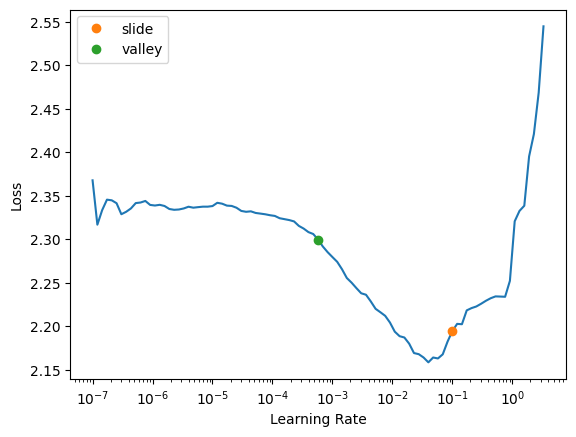

In [23]:
class IdentityDoNothingLayer(nn.Module):
    def __init__(self, ni, nf):
        super(IdentityDoNothingLayer, self).__init__()
        self.weight = nn.Parameter(torch.ones(nf, ni), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(nf), requires_grad=True)

    def forward(self, x):
        return x


# Define the FCN model with optional additional layers
def deep_fcn_model(more_layers=0):
    layers = [
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten()
    ]
    
    # Add the optional additional layers using linear_block
    for _ in range(more_layers):
        layers.append(IdentityDoNothingLayer(256, 256))
    
    # Final output layer
    layers.append(nn.Linear(256, 10))  # Assume dls.c = 10 for simplicity
    
    return nn.Sequential(*layers)

learn = get_learner(deep_fcn_model(more_layers=40), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

If you scroll up and remember our initial fcn_model, that's basically the same loss landscape, there are not much traps, and it's falling very steepely

In [24]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(3, best_lr, wd=0.1)

0.04971228077192791


epoch,train_loss,valid_loss,accuracy,time
0,1.847769,2.112212,0.341401,00:44
1,1.459949,1.425679,0.538599,00:42
2,1.178022,1.162120,0.637452,00:41


### Letting The Model Do Nothing With Skip Connections

SuggestedLRs(slide=0.2089296132326126, valley=0.0002290867705596611)

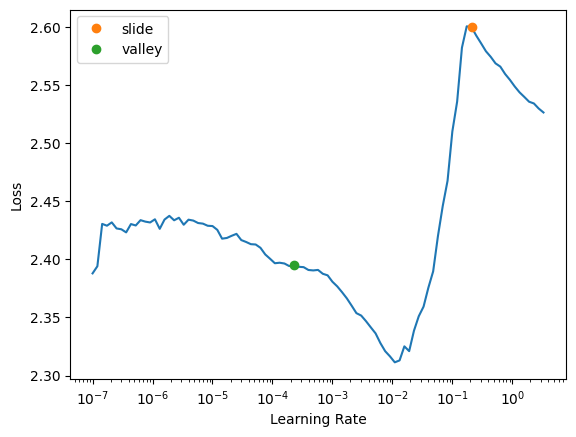

In [25]:
class AdaptiveLinearLayer(nn.Module):
    def __init__(self, ni, nf):
        super(AdaptiveLinearLayer, self).__init__()
        self.weight = nn.Parameter(torch.ones(nf, ni))
        self.bias = nn.Parameter(torch.zeros(nf))
        self.gate = nn.Parameter(torch.tensor(0.0))  # Learnable parameter to blend the paths
        self.batch_norm = nn.BatchNorm1d(nf)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity_output = x
        transformed_output = F.linear(x, self.weight, self.bias)
        # Blend the outputs based on the gate value
        output = self.gate * transformed_output + (1 - self.gate) * identity_output
        # Apply BatchNorm and ReLU
        output = self.batch_norm(output)
        output = self.relu(output)
        return output

# Define the FCN model with optional additional layers
def deep_fcn_model(more_layers=0):
    layers = [
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten()
    ]
    
    # Add the optional additional layers using linear_block
    for _ in range(more_layers):
        layers.append(AdaptiveLinearLayer(256, 256))
    
    # Final output layer
    layers.append(nn.Linear(256, 10))  # Assume dls.c = 10 for simplicity
    
    return nn.Sequential(*layers)

learn = get_learner(deep_fcn_model(more_layers=40), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

OK seems like I am making things worse

In [26]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(3, best_lr, wd=0.1)

0.10435026323102647


epoch,train_loss,valid_loss,accuracy,time
0,2.385462,2.329491,0.099363,00:53
1,2.312991,nan,0.083312,00:54
2,2.304022,nan,0.092484,00:52


It's horrible, it might be the wrong implementation

### Another Attempt

SuggestedLRs(slide=0.02754228748381138, valley=0.009120108559727669)

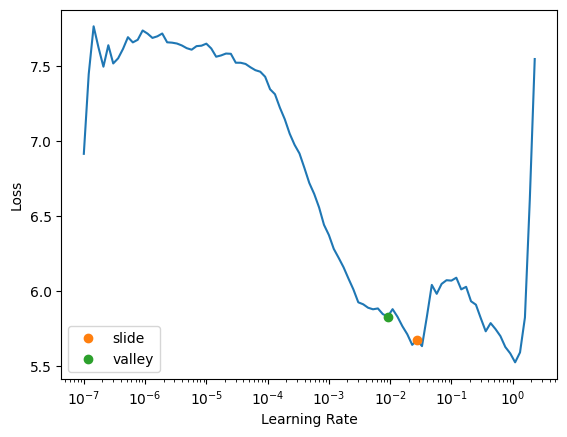

In [27]:
def _linear_block(ni, nf):
    return nn.Sequential(
        nn.Linear(ni, nf),
        nn.BatchNorm1d(nf),
        nn.ReLU(inplace=True),
        nn.Linear(nf, nf),
        nn.BatchNorm1d(nf)
    )

class ResidualLinearBlock(nn.Module):
    def __init__(self, ni, nf):
        super(ResidualLinearBlock, self).__init__()
        self.linears = _linear_block(ni, nf)
        self.idlinear = nn.Linear(ni, nf) if ni != nf else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.linears(x)
        identity = self.idlinear(identity)
        return F.relu(out + identity)


# Define the FCN model with optional additional layers
def deep_fcn_model(more_layers=0):
    layers = [
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten()
    ]
    
    # Add the optional additional layers using linear_block
    for _ in range(more_layers):
        layers.append(ResidualLinearBlock(256, 256))
    
    # Final output layer
    layers.append(nn.Linear(256, 10))  # Assume dls.c = 10 for simplicity
    return nn.Sequential(*layers)


learn = get_learner(deep_fcn_model(more_layers=40), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

In [28]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(3, best_lr, wd=0.1)

0.009211089462041855


epoch,train_loss,valid_loss,accuracy,time
0,3.241454,18.877737,0.191338,01:20
1,2.037225,2.826608,0.294777,01:22
2,1.764609,1.691326,0.426752,01:18


FINALLY IT WORKS!!!

Let's analyze the differences between the two implementations in terms of their logic and impact on training:
1. ResidualLinearBlock Implementation

```python

def _linear_block(ni, nf):
    return nn.Sequential(
        nn.Linear(ni, nf),
        nn.BatchNorm1d(nf),
        nn.ReLU(inplace=True),
        nn.Linear(nf, nf),
        nn.BatchNorm1d(nf)
    )

class ResidualLinearBlock(nn.Module):
    def __init__(self, ni, nf):
        super(ResidualLinearBlock, self).__init__()
        self.linears = _linear_block(ni, nf)
        self.idlinear = nn.Linear(ni, nf) if ni != nf else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.linears(x)
        identity = self.idlinear(identity)
        return F.relu(out + identity)
```
2. AdaptiveLinearLayer Implementation

```python

class AdaptiveLinearLayer(nn.Module):
    def __init__(self, ni, nf):
        super(AdaptiveLinearLayer, self).__init__()
        self.weight = nn.Parameter(torch.ones(nf, ni))
        self.bias = nn.Parameter(torch.zeros(nf))
        self.gate = nn.Parameter(torch.tensor(0.0))  # Learnable parameter to blend the paths
        self.batch_norm = nn.BatchNorm1d(nf)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity_output = x
        transformed_output = F.linear(x, self.weight, self.bias)
        # Blend the outputs based on the gate value
        output = self.gate * transformed_output + (1 - self.gate) * identity_output
        # Apply BatchNorm and ReLU
        output = self.batch_norm(output)
        output = self.relu(output)
        return output
```
Analysis
ResidualLinearBlock

    Logic:
        This block creates a sequence of two linear layers with batch normalization and ReLU in between and after the second layer.
        If the input and output dimensions are different, it uses a linear layer (idlinear) to match the dimensions.
        Adds the original input (identity) to the transformed output and applies a ReLU activation to the result.

    Training Impact:
        Skip Connection: Ensures the original input is added to the output of the transformation, which helps mitigate the vanishing gradient problem and allows deeper networks to train more effectively.
        Dimension Matching: Handles cases where the dimensions of input and output do not match, ensuring that the addition operation is valid.
        Residual Learning: Helps the model learn residual functions, which often leads to better optimization and faster convergence.

AdaptiveLinearLayer

    Logic:
        This layer initializes weights and biases to specific values and includes a learnable gate parameter that controls the blending of the identity path and the transformed output.
        Applies the linear transformation using the weights and biases, blends the output with the identity path based on the gate value, and then applies batch normalization and ReLU activation.

    Training Impact:
        Blending with Gate: The learnable gate parameter determines how much of the transformed output and identity output to mix. This can provide flexibility but might also add complexity to the training process.
        Direct Blending: Instead of simply adding the transformed output and identity, it blends them, which means the network has to learn an additional parameter (the gate) to find the right balance.
        Initialization: The weights are initialized to 1 and biases to 0, which might not always be optimal. The gate starting at 0 means the initial output is the identity path, and the network needs to learn to utilize the transformed path.

Differences in Logic and Training

    Residual Connection vs. Blending:
        ResidualLinearBlock: Uses a standard residual connection, adding the input directly to the transformed output.
        AdaptiveLinearLayer: Uses a blending mechanism controlled by a learnable gate parameter, which adds flexibility but can complicate the training process.

    Learning Complexity:
        ResidualLinearBlock: Simpler learning dynamics with a straightforward addition operation, leveraging the strengths of residual learning.
        AdaptiveLinearLayer: Introduces additional complexity by learning how much of the transformed output to use through the gate parameter, which can be both a strength and a weakness depending on the task.

    Initialization:
        ResidualLinearBlock: Standard initialization techniques for linear layers, relying on PyTorch defaults or custom initializations.
        AdaptiveLinearLayer: Explicitly initializes weights and biases to fixed values, which may not always be ideal and might require adjustment during training.

    Flexibility vs. Stability:
        ResidualLinearBlock: Provides stability and leverages residual learning for better optimization in deep networks.
        AdaptiveLinearLayer: Offers more flexibility with the learnable gate but at the cost of potential instability or slower convergence during training.

Conclusion

While both implementations aim to improve training dynamics in deep networks, they take different approaches. The ResidualLinearBlock follows the conventional residual learning method, which is straightforward and effective for most deep learning tasks. The AdaptiveLinearLayer, on the other hand, introduces a blending mechanism with a learnable gate, offering more flexibility but potentially complicating the training process. Depending on the specific needs of your task, you might prefer one approach over the other. For standard deep learning tasks, the ResidualLinearBlock is likely to be more stable and effective.

### Do the Additional Layers Really Are Identity Mapping?

The last thing to verify is to look at the weights and see how much they moved, did the model learned to not moved them too much? It's a bit hard to tell because we didn't ask the model to give us same result as the original model, we just ask them to keep optimizing as usual.

# This Is The Power Of ResNets

I  haven't been able to create a skip connection with linear layer, but this is how you do it with conv layer according to the resnet paper

### With Few Layers It Works Well

In [29]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

def block(ni, nf, stride=2):
    return ResBlock(ni, nf, stride=stride)

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

def resnet_model(more_layers=0):
    layers = [
        block(3, 16, stride=2),
        block(16, 32, stride=2),
        block(32, 64, stride=2),
        block(64, 128, stride=2),
        block(128, 256, stride=2),
    ]
    
    # Add the optional additional layers using more_layers
    for _ in range(more_layers):
        layers.append(ResBlock(256, 256, stride=1))

    layers.append(nn.AdaptiveAvgPool2d(1))
    layers.append(nn.Flatten())
    
    # Final output layer
    layers.append(nn.Linear(256, 10))  # Assume dls.c = 10 for simplicity
    return nn.Sequential(*layers)

SuggestedLRs(slide=0.02290867641568184, valley=0.0012022644514217973)

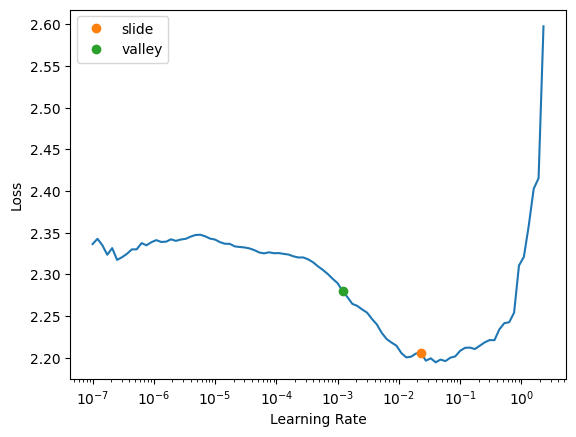

In [30]:
learn = get_learner(resnet_model(more_layers=1), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

In [31]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(5, best_lr, wd=0.1)

0.01085320598213002


epoch,train_loss,valid_loss,accuracy,time
0,1.809669,1.825991,0.402548,01:16
1,1.476844,1.731919,0.440510,01:12
2,1.192131,1.164184,0.624459,01:12
3,0.982502,0.883992,0.716433,01:16
4,0.828087,0.834457,0.735032,01:19


### And The Same Model With 40 More Layers Still Work AS WELL!

SuggestedLRs(slide=0.007585775572806597, valley=0.0008317637839354575)

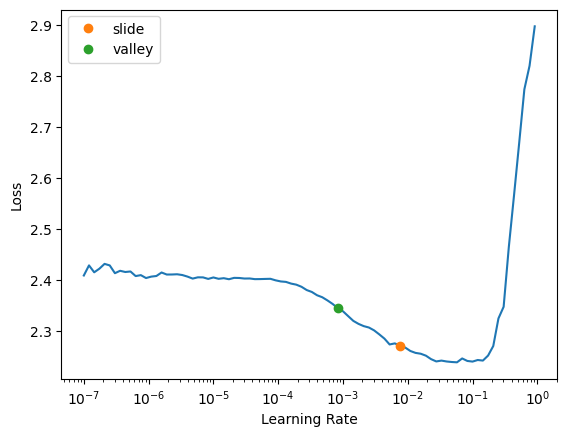

In [32]:
learn = get_learner(resnet_model(more_layers=40), bs=64)
lr_info = learn.lr_find(suggest_funcs=(slide, valley))
lr_info

In [33]:
best_lr = abs(lr_info[1] - lr_info[0]) / 2
print(best_lr)
learn.fit_one_cycle(5, best_lr, wd=0.1)

0.0033770058944355696


epoch,train_loss,valid_loss,accuracy,time
0,1.810682,1.798644,0.400764,02:48
1,1.531390,1.387603,0.554904,02:40
2,1.279292,1.623538,0.497834,02:42
3,1.033128,0.975636,0.682548,02:41
4,0.914281,0.963699,0.688662,02:40


# a SOTA ResNet

Most of the progress in a deep convolutional neural net occurs in the early layers. Why is that?

Because they process more information, the inputs is still very big and raw. (wait isn't this contradictory with the notion of receptive fields?)

Another reason is that a ResNetBlock takes more computation than a plain conv block since a ResNet block has 3 conv layers and a pooling layer.

That's why the stem of the ResNet should

In [1]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

We use BottleNeck Blocks which have losange shapes:
1. 1 1x1 kernel
2. 1 3x3 kernel
3. 1 3x3 kernel

They are faster to compute

In [9]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [10]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])